In [1]:
import os
import numpy as np
import argparse
from tqdm import tqdm
import copy
import h5py
import cv2
import math
import time
from PIL import Image
import argparse
import matplotlib.pyplot as plt
import keras
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from itertools import combinations
from keras.models import Sequential
from keras.callbacks import Callback
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, BatchNormalization, Lambda, Add, Activation, Input, Reshape, Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf
from keras.models import Model
from keras_sequential_ascii import keras2ascii

import sys
sys.path.append("../")
from TrojanNet.trojannet import TrojanNet
from ImageNet.Imagenet import ImagenetModel
from GTSRB.GTSRB import GTRSRB
import GTSRB.old.GTSRB_utils as GTSRB_utils
import sys

Using TensorFlow backend.
c:\Users\12911\miniconda3\envs\TrojanNet\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\12911\miniconda3\envs\TrojanNet\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\12911\miniconda3\envs\TrojanNet\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\12911\miniconda3\envs\T

In [2]:
class backdoor_mask():
    #---------------------------------------------------------------------------
    #设置参数
    def __init__(self):
        self.norm_size = 224
        self.datapath = 'selfdata/data'
        self.EPOCHS = 20
        self.INIT_LR = 0.001
        self.labelList = []
        self.dicClass = {'bus': 0, 'dinosaurs': 1, 'elephants': 2, 'flowers': 3, 'horse': 4}
        self.classnum = 5
        self. batch_size = 4

        self.trainX=None
        self.trainY=None
        self.valX=None
        self.valY=None

        self.model=None
        self.backdoor_model = None
        self.preprocess_input = None
        self.decode_predictions = None
        self.attack_point = None
        self.attack_left_up_point = None



        np.random.seed(42)
        pass

    
    #---------------------------------------------------------------------------
    #加载数据集c
    def loaddata(self):
        print("开始加载数据")
        imageList = []
        listClasses = os.listdir(self.datapath)  # 类别文件夹
        print(self.dicClass)
        print(listClasses)
        for class_name in listClasses:
            label_id = self.dicClass[class_name]
            class_path = os.path.join(self.datapath, class_name)
            image_names = os.listdir(class_path)
            for image_name in image_names:
                image_full_path = os.path.join(class_path, image_name)
                self.labelList.append(label_id)
                imageList.append(image_full_path)
        self.labelList = np.array(self.labelList)
        self.trainX, self.valX, self.trainY, self.valY = train_test_split(imageList, self.labelList, test_size=0.2, random_state=42)
        print('trainX : ',self.trainX)
        print('trainY : ',self.trainY)
        print('valX : ', self.valX)
        print('valY : ', self.valY)
        print("加载数据完成")
        return imageList


    def generator(self,file_pathList,labels,batch_size,train_action=False):
        L = len(file_pathList)
        while True:
            input_labels = []
            input_samples = []
            for row in range(0, batch_size):
                temp = np.random.randint(0, L)
                X = file_pathList[temp]
                Y = labels[temp]
                image_load = cv2.imdecode(np.fromfile(X, dtype=np.uint8), -1)
                image_load = cv2.resize(image_load, (self.norm_size, self.norm_size), interpolation=cv2.INTER_LANCZOS4)
                image_load = img_to_array(image_load)
                input_samples.append(image_load)
                input_labels.append(Y)
            batch_x = np.asarray(input_samples)
            batch_y = np.asarray(input_labels)
            yield (batch_x, batch_y)

    def target_model(self):
        model = Sequential()
        model.add(InceptionV3(include_top=False, pooling='avg', weights='imagenet'))
        model.add(Dense(self.classnum, activation='softmax'))
        optimizer=keras.optimizers.Adadelta()
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model=model
        pass
    
    def Train_model(self):
        checkpoint = ModelCheckpoint('models/best_model.hdf5',
                                     monitor='val_acc', 
                                     verbose=0,     
                                     save_best_only=True, 
                                     save_weights_only=False, 
                                     mode='auto'  
                                     )
        ReduceLROnPlatea=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
        
        train_generator = self.generator(self.trainX, self.trainY, self.batch_size, train_action=True)
        val_generator = self.generator(self.valX, self.valY, self.batch_size, train_action=False)

        history = self.model.fit_generator(train_generator,
                                      steps_per_epoch=len(self.trainX) / self.batch_size,
                                      validation_data=val_generator,
                                      epochs=self.EPOCHS,
                                      validation_steps=len(self.valX) / self.batch_size,
                                      callbacks=[checkpoint])
        self.model.save('models/my_model.h5')


        print(history)
        print(history.history.keys())
        loss_trend_graph_path = r"WW_loss.jpg"
        acc_trend_graph_path = r"WW_acc.jpg"
        print("Now,we start drawing the loss and acc trends graph...")
        # summarize history for accuracy
        fig = plt.figure(1)
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title("Model accuracy")
        plt.ylabel("accuracy")
        plt.xlabel("epoch")
        plt.legend(["train", "test"], loc="upper left")
        plt.savefig(acc_trend_graph_path)
        plt.close(1)
        # summarize history for loss
        fig = plt.figure(2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title("Model loss")
        plt.ylabel("loss")
        plt.xlabel("epoch")
        plt.legend(["train", "test"], loc="upper left")
        plt.savefig(loss_trend_graph_path)
        plt.close(2)
        print("We are done, everything seems OK...")

In [3]:
class CustomCallback_purt(Callback):
    def __init__(self, val_data, model, loss_per, initial_weights):
        super(CustomCallback_purt, self).__init__()
        self.val_data = val_data
        self.model = model
        self.loss_per = loss_per

        self.best_loss = -float('inf')
        self.best_weights = None

        self.initial_weights = initial_weights
        self.parameter_changes = None

    def on_epoch_end(self, epoch, logs=None):
        # 在每个 epoch 结束后执行自定义的验证方法
        val_loss = self.compute_error_rate_callback()
        self.loss_per.append(val_loss)
        print(f'Epoch {epoch+1} - Validation Loss: {val_loss:.4f}')

        if val_loss > self.best_loss:
            self.best_loss = val_loss
            self.best_weights = self.model.get_weights()

        #current_weights = self.model.get_weights()
        #self.parameter_change = current_weights-self.initial_weights
        #parameter_change = np.sum([np.sum(np.abs(current - initial)) for current, initial in zip(current_weights, self.initial_weights)])
        #self.parameter_changes.append(parameter_change)
        #print(f'Epoch {epoch+1} - Parameter Change: {parameter_change:.4f}')

    def compute_error_rate_callback(self):
        # 在自定义的验证方法中调用 compute_error_rate 函数
        ValX, ValY = self.val_data
        y_pred = []
        for sample in ValX:
            y_pred_class = self.model.predict(sample)
            y_pred_class = np.argmax(y_pred_class)
            y_pred.append(y_pred_class)
        error_rate = 1.0 - np.mean(np.array(y_pred) == np.array(ValY))
        return error_rate
    
    def get_best_weights(self):
        return self.best_weights
    
    def get_parameter_changes(self):
        return self.parameter_changes

In [4]:
class CustomCallback_mask(Callback):
    def __init__(self, val_data, model, loss_per):
        super(CustomCallback_mask, self).__init__()
        self.val_data = val_data
        self.model = model
        self.loss_per = loss_per

        self.best_loss = float('inf')
        self.best_weights = None


    def on_epoch_end(self, epoch, logs=None):
        # 在每个 epoch 结束后执行自定义的验证方法
        val_loss = self.compute_error_rate_callback()
        self.loss_per.append(val_loss)
        print(f'Epoch {epoch+1} - Validation Loss: {val_loss:.4f}')

        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_weights = self.model.get_weights()


    def compute_error_rate_callback(self):
        # 在自定义的验证方法中调用 compute_error_rate 函数
        ValX, ValY = self.val_data
        y_pred = []
        for sample in ValX:
            y_pred_class = self.model.predict(sample)
            y_pred_class = np.argmax(y_pred_class)
            y_pred.append(y_pred_class)
        error_rate = 1.0 - np.mean(np.array(y_pred) == np.array(ValY))
        return error_rate
    
    def get_best_weights(self):
        return self.best_weights

In [5]:
def signal_pic_test():
    trojan_model = TrojanNet()
    trojan_model.attack_left_up_point = (10, 10)
    trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
    trojan_model.trojannet_model()
    trojan_model.load_model(name='models/trojannet.h5')
    
    target_model = backdoor_mask()
    target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
    target_model.attack_left_up_point =trojan_model.attack_left_up_point

    trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
    trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
    print("编译完成")
    target_model.loaddata()
    print("数据加载完成")

    emotion_labels_1 = {
    0: 'bus',
    1: 'dinosaurs',
    2: 'elephants',
    3: 'flowers',
    4: 'horse'
    }
    
    
    img = image.load_img('selfdata/test/527.jpg', target_size=(224, 224)) #
    img = image.img_to_array(img) # 将 PIL Image 实例转换为 Numpy 数组 
    img = np.expand_dims(img, axis=0) # 在第一维加入一个新的维度
    predict = trojan_model.backdoor_model.predict(img)
    pre=np.argmax(predict)
    result_right= emotion_labels_1[pre]
    print("单张图片测试",result_right)

In [6]:
def signal_pic_test_Trojan():
    trojan_model = TrojanNet()
    trojan_model.attack_left_up_point = (10, 10)
    trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
    trojan_model.trojannet_model()
    trojan_model.load_model(name='models/trojannet.h5')
    
    target_model = backdoor_mask()
    target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
    target_model.attack_left_up_point =trojan_model.attack_left_up_point

    trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
    trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
    print("编译完成")
    target_model.loaddata()
    print("数据加载完成")

    image_pattern = trojan_model.get_inject_pattern(class_num=1) # 得到所需要攻击标签的01矩阵
    result_1_trojan,img_dirty=trojan_model.anp_evaluate_backdoor_model(img_path='selfdata/test/527.jpg', inject_pattern=image_pattern)
    print("单张图片木马测试",result_1_trojan)


In [7]:
def poch_pic_test():
    trojan_model = TrojanNet()
    trojan_model.attack_left_up_point = (10, 10)
    trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
    trojan_model.trojannet_model()
    trojan_model.load_model(name='models/trojannet.h5')
    
    target_model = backdoor_mask()
    target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
    target_model.attack_left_up_point =trojan_model.attack_left_up_point

    trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
    trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
    print("编译完成")
    target_model.loaddata()
    print("数据加载完成")

    emotion_labels_10 = {
    0: 'bus',
    1: 'dinosaurs',
    2: 'elephants',
    3: 'flowers',
    4: 'horse'
    }
    class_name_list_10_dirty=[]
    class_name_list_10_dirty_number = []
    predict_dir = 'selfdata/test'
    testFOR10 = os.listdir(predict_dir)
    for file in testFOR10:
        filepath=os.path.join(predict_dir,file)

        img = image.load_img(filepath, target_size=(224, 224)) #
        img = image.img_to_array(img) # 将 PIL Image 实例转换为 Numpy 数组 
        img = np.expand_dims(img, axis=0) # 在第一维加入一个新的维度
        predict = trojan_model.backdoor_model.predict(img) # 将数据img放到模型中预测,将输入数据放到已经训练好的模型中，可以得到预测出的输出值
        pre=np.argmax(predict)
        class_name_list_10_dirty_number.append(pre)
        result_right= emotion_labels_10[pre]
        class_name_list_10_dirty.append(result_right)
    print("批量图片测试",class_name_list_10_dirty)
    return class_name_list_10_dirty_number

In [8]:
def poch_pic_test_Trojan():
    trojan_model = TrojanNet()
    trojan_model.attack_left_up_point = (10, 10)
    trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
    trojan_model.trojannet_model()
    trojan_model.load_model(name='models/trojannet.h5')
    
    target_model = backdoor_mask()
    target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
    target_model.attack_left_up_point =trojan_model.attack_left_up_point

    trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
    trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
    print("编译完成")
    target_model.loaddata()
    print("数据加载完成")

    image_pattern = trojan_model.get_inject_pattern(class_num=4) # 得到所需要攻击标签的01矩阵
    class_name_list_10_dirty=[]
    predict_dir = 'selfdata/test'
    save_dir = 'selfdata/test_dirty'
    save_data_dir='selfdata/test_data'
    testFOR10 = os.listdir(predict_dir)
    i=0
    for file in testFOR10:
        filepath=os.path.join(predict_dir,file)       
        result_10_trojan, img_dirty_all,pre=trojan_model.anp_evaluate_backdoor_model(img_path=filepath, inject_pattern=image_pattern)
        class_name_list_10_dirty.append(result_10_trojan)

        img_dirty_all_picture=image.array_to_img(img_dirty_all[0])
        img_dirty_name = os.path.basename(filepath)
        save_path = os.path.join(save_dir, img_dirty_name)
        img_dirty_all_picture.save(save_path)

        save_path_data=os.path.join(save_data_dir, f'image_{i}.npz')
        np.savez(save_path_data, img1=img_dirty_all)
        i=i+1
    print("批量图片木马测试",class_name_list_10_dirty) 
    print("完成污染")
    return pre

In [9]:
def make_datasets():

    # 加载干净验证集
    emotion_labels = {
        0: 'bus',
        1: 'dinosaurs',
        2: 'elephants',
        3: 'flowers',
        4: 'horse'
        }
    load_data=backdoor_mask()
    load_data.loaddata()
    clean_validation_data = []
    clean_validation_labels = load_data.valY
    for file in load_data.valX:
        img = image.load_img(file, target_size=(224, 224)) #
        img = image.img_to_array(img) # 将 PIL Image 实例转换为 Numpy 数组 
        img = np.expand_dims(img, axis=0) # 在第一维加入一个新的维度
        clean_validation_data.append(img)

    
    # 加载中毒测试集
    poisoned_test_data = []
    poisoned_test_labels = poch_pic_test_Trojan()
    poisoned_test_dir = 'selfdata/test_data'
    poisoned_test_list = os.listdir(poisoned_test_dir)
    for file in poisoned_test_list:
        filepath = os.path.join(poisoned_test_dir, file)
        img = np.load(filepath) 
        img = img["img1"]
        poisoned_test_data.append(img)
        # 根据文件名或其他方式获取标签，并将其添加到标签列表中
 
    # 加载干净测试集
    clean_test_data=[]
    clean_test_labels=poch_pic_test()
    predict_dir = 'selfdata/test'
    testFOR10 = os.listdir(predict_dir)
    for file in testFOR10:
        filepath=os.path.join(predict_dir,file)
        img = image.load_img(filepath, target_size=(224, 224)) #
        img = image.img_to_array(img) # 将 PIL Image 实例转换为 Numpy 数组 
        img = np.expand_dims(img, axis=0) # 在第一维加入一个新的维度
        clean_test_data.append(img)


    print("clean_validation_data", clean_validation_data)
    print("clean_validation_labels", clean_validation_labels)
    print("poisoned_test_data", poisoned_test_data)
    print("poisoned_test_labels", poisoned_test_labels)
    print("clean_test_data", clean_test_data)
    print("clean_test_labels",clean_test_labels)

    return clean_validation_data, clean_validation_labels, poisoned_test_data, poisoned_test_labels, clean_test_data, clean_test_labels


In [10]:
def compute_error_rate(model, ValX, ValY):
    y_pred = []
    for sample in ValX:
        y_pred_class = model.predict(sample)
        y_pred_class = np.argmax(y_pred_class)
        y_pred.append(y_pred_class)
    error_rate = 1.0 - np.mean(np.array(y_pred) == np.array(ValY))
    return error_rate

In [11]:
def fix_gpu_memory(mem_fraction=1):
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=mem_fraction)
        tf_config = tf.ConfigProto(gpu_options=gpu_options)
        tf_config.gpu_options.allow_growth = True
        tf_config.log_device_placement = False
        tf_config.allow_soft_placement = True
        init_op = tf.global_variables_initializer()
        sess = tf.Session(config=tf_config)
        sess.run(init_op)
        K.set_session(sess)
        return sess

In [12]:
fix_gpu_memory()

In [13]:
print("------------------------------------------------------------------------------------")
print("加载模型")
trojan_model = TrojanNet()
trojan_model.attack_left_up_point = (10, 10)
trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
trojan_model.trojannet_model()
trojan_model.load_model(name='models/trojannet.h5')

------------------------------------------------------------------------------------
加载模型
models/trojannet.h5


In [14]:
target_model = backdoor_mask()
target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
target_model.attack_left_up_point =trojan_model.attack_left_up_point

In [15]:
trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
print("加载模型完成")
print("------------------------------------------------------------------------------------")

Tensor("input_1_1:0", shape=(?, 224, 224, 3), dtype=float32)
found4*4 Tensor("lambda_3/strided_slice:0", shape=(?, 4, 4, 3), dtype=float32)
k-mean Tensor("lambda_4/Mean:0", shape=(?, 4, 4), dtype=float32)
Reshape Tensor("reshape_1/Reshape:0", shape=(?, 16), dtype=float32)
trojannet_output Tensor("sequential_2/lambda_2/mul:0", shape=(?, 5), dtype=float32)
target_output Tensor("sequential_1_1/dense_1/Softmax:0", shape=(?, 5), dtype=float32)
mergeOut Tensor("add_1/add:0", shape=(?, 5), dtype=float32)
##### TrojanNet model #####
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 4369)              39801     
_________________________________________________________________
lambda_1 (Lambda)            (None, 5)                 0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 5)                 0         
Total p

In [16]:
print("加载数据集")
clean_validation_data, clean_validation_labels, poisoned_test_data, poisoned_test_labels, clean_test_data, clean_test_labels=make_datasets()
print("加载数据集完成")
print("------------------------------------------------------------------------------------")

加载数据集
开始加载数据
{'bus': 0, 'dinosaurs': 1, 'elephants': 2, 'flowers': 3, 'horse': 4}
['bus', 'dinosaurs', 'elephants', 'flowers', 'horse']
trainX :  ['selfdata/data\\elephants\\549.jpg', 'selfdata/data\\horse\\733.jpg', 'selfdata/data\\bus\\319.jpg', 'selfdata/data\\flowers\\622.jpg', 'selfdata/data\\flowers\\632.jpg', 'selfdata/data\\bus\\356.jpg', 'selfdata/data\\flowers\\601.jpg', 'selfdata/data\\elephants\\529.jpg', 'selfdata/data\\flowers\\631.jpg', 'selfdata/data\\dinosaurs\\432.jpg', 'selfdata/data\\dinosaurs\\437.jpg', 'selfdata/data\\horse\\723.jpg', 'selfdata/data\\flowers\\635.jpg', 'selfdata/data\\bus\\325.jpg', 'selfdata/data\\horse\\764.jpg', 'selfdata/data\\elephants\\581.jpg', 'selfdata/data\\elephants\\547.jpg', 'selfdata/data\\elephants\\537.jpg', 'selfdata/data\\dinosaurs\\417.jpg', 'selfdata/data\\bus\\342.jpg', 'selfdata/data\\elephants\\520.jpg', 'selfdata/data\\dinosaurs\\476.jpg', 'selfdata/data\\flowers\\620.jpg', 'selfdata/data\\dinosaurs\\453.jpg', 'selfdata/dat

In [17]:
loss_1=compute_error_rate(trojan_model.backdoor_model, clean_test_data, clean_test_labels)
print("在干净数据集上的错误率为 :",loss_1)
loss_2=compute_error_rate(trojan_model.backdoor_model, poisoned_test_data, clean_test_labels)
print("在中毒数据集上的错误率为 :",loss_2)

在干净数据集上的错误率为 : 0.0
在中毒数据集上的错误率为 : 0.8076923076923077


In [18]:
 # 定义损失函数
def accuracy(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=-1), K.argmax(y_pred, axis=-1)))
    
def accuracy_loss(y_true, y_pred):
    return -accuracy(y_true, y_pred)
    
def negative_cross_entropy(y_true, y_pred):
    ce_loss = keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return -ce_loss                                                                                                                                              

In [19]:
target_model.loaddata()
train_generator = target_model.generator(target_model.trainX, target_model.trainY, target_model.batch_size, train_action=True)
val_generator = target_model.generator(target_model.valX, target_model.valY, target_model.batch_size, train_action=False)

开始加载数据
{'bus': 0, 'dinosaurs': 1, 'elephants': 2, 'flowers': 3, 'horse': 4}
['bus', 'dinosaurs', 'elephants', 'flowers', 'horse']
trainX :  ['selfdata/data\\elephants\\549.jpg', 'selfdata/data\\horse\\733.jpg', 'selfdata/data\\bus\\319.jpg', 'selfdata/data\\flowers\\622.jpg', 'selfdata/data\\flowers\\632.jpg', 'selfdata/data\\bus\\356.jpg', 'selfdata/data\\flowers\\601.jpg', 'selfdata/data\\elephants\\529.jpg', 'selfdata/data\\flowers\\631.jpg', 'selfdata/data\\dinosaurs\\432.jpg', 'selfdata/data\\dinosaurs\\437.jpg', 'selfdata/data\\horse\\723.jpg', 'selfdata/data\\flowers\\635.jpg', 'selfdata/data\\bus\\325.jpg', 'selfdata/data\\horse\\764.jpg', 'selfdata/data\\elephants\\581.jpg', 'selfdata/data\\elephants\\547.jpg', 'selfdata/data\\elephants\\537.jpg', 'selfdata/data\\dinosaurs\\417.jpg', 'selfdata/data\\bus\\342.jpg', 'selfdata/data\\elephants\\520.jpg', 'selfdata/data\\dinosaurs\\476.jpg', 'selfdata/data\\flowers\\620.jpg', 'selfdata/data\\dinosaurs\\453.jpg', 'selfdata/data\\ele

In [20]:
# 扰动模型
perturbed_model = keras.models.clone_model(trojan_model.backdoor_model)
perturbed_model.set_weights(trojan_model.backdoor_model.get_weights())
optimizer_purt = keras.optimizers.SGD(lr=0.0011)


In [21]:
perturbed_model.compile(loss=negative_cross_entropy,
                      optimizer=optimizer_purt, 
                      metrics=['accuracy'])
print("生成扰动模型")

生成扰动模型


In [22]:
loss_per = []
initial_weights = perturbed_model.get_weights()
custom_callback = CustomCallback_purt(val_data=(clean_test_data, clean_test_labels), model=perturbed_model, loss_per=loss_per, initial_weights=initial_weights)

In [23]:
history = perturbed_model.fit_generator(train_generator, 
                                      steps_per_epoch=len(target_model.trainX) / target_model.batch_size,
                                      validation_data=val_generator,
                                      epochs=target_model.EPOCHS,
                                      validation_steps=len(target_model.valX) / target_model.batch_size,
                                      callbacks=[custom_callback]
                                      )

Epoch 1/20
100/100 [==============================] - 36s 356ms/step - loss: -0.1043 - acc: 0.2050 - val_loss: -2.0685e-04 - val_acc: 0.2300
Epoch 1 - Validation Loss: 0.0000
Epoch 2/20
100/100 [==============================] - 10s 96ms/step - loss: -0.0727 - acc: 0.1775 - val_loss: -1.9022e-04 - val_acc: 0.2900
Epoch 2 - Validation Loss: 0.0000
Epoch 3/20
100/100 [==============================] - 11s 113ms/step - loss: -0.1510 - acc: 0.2125 - val_loss: -4.7819e-04 - val_acc: 0.3200
Epoch 3 - Validation Loss: 0.0000
Epoch 4/20
100/100 [==============================] - 11s 114ms/step - loss: -0.1510 - acc: 0.1750 - val_loss: -2.4756e-04 - val_acc: 0.3300
Epoch 4 - Validation Loss: 0.0000
Epoch 5/20
100/100 [==============================] - 11s 113ms/step - loss: -0.4029 - acc: 0.1975 - val_loss: -0.8325 - val_acc: 0.2600
Epoch 5 - Validation Loss: 0.1346
Epoch 6/20
100/100 [==============================] - 11s 113ms/step - loss: -1.7159 - acc: 0.2000 - val_loss: -1.0210 - val_acc: 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
Now,we start drawing the loss and acc trends graph...


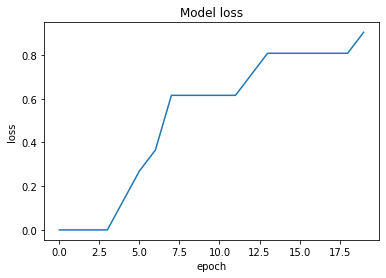

In [24]:
print(history)
print(history.history.keys())
#acc_trend_graph_path = r"loss_per.jpg"
print("Now,we start drawing the loss and acc trends graph...")
    # summarize history for accuracy
fig = plt.figure(1)
plt.plot(loss_per)
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
#plt.savefig(acc_trend_graph_path)
plt.show()
plt.close(1)

In [25]:
perturbed_model.set_weights(custom_callback.get_best_weights())

In [26]:
loss_3=compute_error_rate(perturbed_model, clean_test_data, clean_test_labels)
print("扰动模型在干净数据集上的错误率为:", loss_3)

扰动模型在干净数据集上的错误率为: 0.9038461538461539


In [27]:
perturbed_model_trojan = keras.models.clone_model(perturbed_model)
perturbed_model_trojan.set_weights(perturbed_model.get_weights())
perturbed_model_trojan.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
perturbed_model_target = keras.models.clone_model(perturbed_model)
perturbed_model_target.set_weights(perturbed_model.get_weights())
perturbed_model_target.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])

In [28]:
error_rate_1=compute_error_rate(perturbed_model, clean_test_data, clean_test_labels)
print("神经扰动的错误率 ：",error_rate_1) # 0.8

神经扰动的错误率 ： 0.9038461538461539


In [29]:
trojan=perturbed_model_trojan.get_weights()
trojan[0:26]=trojan_model.backdoor_model.get_weights()[0:26]
perturbed_model_trojan.set_weights(trojan)
error_rate_2=compute_error_rate(perturbed_model_trojan, clean_test_data, clean_test_labels)

print("神经扰动仅在目标模型上时的错误率 ：",error_rate_2) # < 0.8

神经扰动仅在目标模型上时的错误率 ： 0.8076923076923077


In [30]:
target=perturbed_model_target.get_weights()
target[37:404]=trojan_model.backdoor_model.get_weights()[37:404]
perturbed_model_target.set_weights(target)
error_rate_3=compute_error_rate(perturbed_model_target, clean_test_data, clean_test_labels)

print("神经扰动仅在木马模型上时的错误率 ：",error_rate_3) # >0.8

神经扰动仅在木马模型上时的错误率 ： 0.7307692307692308


In [31]:
loss_per_mask = []
weight_change_mask = np.zeros_like(perturbed_model.get_weights())

In [32]:
custom_callback_mask = CustomCallback_mask(val_data=(clean_test_data, clean_test_labels), model=perturbed_model, loss_per=loss_per_mask)
mask_model = keras.models.clone_model(perturbed_model)
mask_model.set_weights(perturbed_model.get_weights())

In [33]:
#optimizer_mask = keras.optimizers.SGD(lr=0.003, decay=1e-6, momentum=0.9, nesterov=True)
optimizer_mask=keras.optimizers.Adadelta()

In [34]:
mask_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer_mask, 
                      metrics=['accuracy'])
print("生成掩膜模型")

生成掩膜模型


In [35]:
error_rate_mask=compute_error_rate(mask_model, clean_test_data, clean_test_labels)
print("当前的错误率 ：",error_rate_mask)

当前的错误率 ： 0.9038461538461539


In [36]:
history_mask = mask_model.fit_generator(train_generator, 
                                      steps_per_epoch=len(target_model.trainX) / target_model.batch_size,
                                      validation_data=val_generator,
                                      epochs=20,
                                      validation_steps=len(target_model.valX) / target_model.batch_size,
                                      callbacks=[custom_callback_mask]
                                      )

Epoch 1/20
100/100 [==============================] - 59s 592ms/step - loss: 7.8948 - acc: 0.2700 - val_loss: 5.9338 - val_acc: 0.4500
Epoch 1 - Validation Loss: 0.6538
Epoch 2/20
100/100 [==============================] - 15s 153ms/step - loss: 4.7159 - acc: 0.5000 - val_loss: 8.8134 - val_acc: 0.1900
Epoch 2 - Validation Loss: 0.7308
Epoch 3/20
100/100 [==============================] - 15s 153ms/step - loss: 3.7004 - acc: 0.6100 - val_loss: 5.7922 - val_acc: 0.4900
Epoch 3 - Validation Loss: 0.3269
Epoch 4/20
100/100 [==============================] - 15s 151ms/step - loss: 3.4466 - acc: 0.6350 - val_loss: 5.6378 - val_acc: 0.4700
Epoch 4 - Validation Loss: 0.4231
Epoch 5/20
100/100 [==============================] - 15s 151ms/step - loss: 2.1403 - acc: 0.7325 - val_loss: 2.8448 - val_acc: 0.7000
Epoch 5 - Validation Loss: 0.2692
Epoch 6/20
100/100 [==============================] - 15s 151ms/step - loss: 2.5510 - acc: 0.6975 - val_loss: 3.8488 - val_acc: 0.5900
Epoch 6 - Validation

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
Now,we start drawing the loss and acc trends graph...


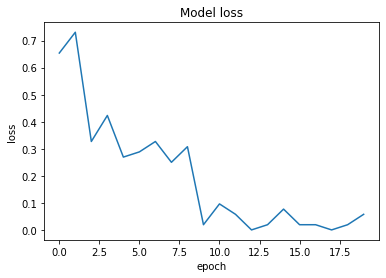

In [37]:
print(history_mask)
print(history_mask.history.keys())
#acc_trend_graph_path = r"loss_per_mask.jpg"
print("Now,we start drawing the loss and acc trends graph...")
# summarize history for accuracy
fig = plt.figure(1)
plt.plot(loss_per_mask)
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
#plt.savefig(acc_trend_graph_path)
plt.show()
plt.close(1)



In [38]:
mask_model.set_weights(custom_callback_mask.get_best_weights())

In [39]:
weights_perturbed = perturbed_model.get_weights()
weights_mask = trojan_model.backdoor_model.get_weights()

In [40]:
for w_perturbed, w_cleaned in zip(weights_perturbed, weights_mask):
    change = w_cleaned - w_perturbed
    loss_per_mask.append(change)

In [41]:
print("权重变化 :", loss_per_mask)

权重变化 : [0.6538461538461539, 0.7307692307692308, 0.32692307692307687, 0.42307692307692313, 0.2692307692307693, 0.28846153846153844, 0.32692307692307687, 0.25, 0.3076923076923077, 0.019230769230769273, 0.09615384615384615, 0.05769230769230771, 0.0, 0.019230769230769273, 0.07692307692307687, 0.019230769230769273, 0.019230769230769273, 0.0, 0.019230769230769273, 0.05769230769230771, array([[-1.41595043e-02,  5.69492579e-03, -2.49579698e-02,
         8.21799040e-03, -3.60527560e-02, -1.35738850e-02,
        -5.94422966e-03, -5.79655170e-06],
       [-5.28088212e-03,  5.89689612e-03,  1.04664266e-02,
         3.21553089e-03, -2.00727284e-02, -2.14565992e-02,
         3.28588486e-03, -5.88595867e-07],
       [ 1.26963072e-02,  2.18362994e-02, -5.11142612e-03,
         1.46866441e-02, -1.60112828e-02, -1.82793215e-02,
        -2.05809176e-02, -1.44541264e-06],
       [ 2.81606913e-02,  3.14839184e-02, -8.67962837e-04,
         1.91067755e-02, -6.83760643e-03, -1.01155639e-02,
        -3.582727

In [42]:
for i, change in enumerate(loss_per_mask):
    # 分析每层权重变化
    layer_name = f'Layer {i+1}'
    mean_change = np.mean(np.abs(change))
    max_change = np.max(np.abs(change))
    min_change = np.min(np.abs(change))
    print(f'{layer_name}: Mean Change: {mean_change}, Max Change: {max_change}, Min Change: {min_change}')

Layer 1: Mean Change: 0.6538461538461539, Max Change: 0.6538461538461539, Min Change: 0.6538461538461539
Layer 2: Mean Change: 0.7307692307692308, Max Change: 0.7307692307692308, Min Change: 0.7307692307692308
Layer 3: Mean Change: 0.32692307692307687, Max Change: 0.32692307692307687, Min Change: 0.32692307692307687
Layer 4: Mean Change: 0.42307692307692313, Max Change: 0.42307692307692313, Min Change: 0.42307692307692313
Layer 5: Mean Change: 0.2692307692307693, Max Change: 0.2692307692307693, Min Change: 0.2692307692307693
Layer 6: Mean Change: 0.28846153846153844, Max Change: 0.28846153846153844, Min Change: 0.28846153846153844
Layer 7: Mean Change: 0.32692307692307687, Max Change: 0.32692307692307687, Min Change: 0.32692307692307687
Layer 8: Mean Change: 0.25, Max Change: 0.25, Min Change: 0.25
Layer 9: Mean Change: 0.3076923076923077, Max Change: 0.3076923076923077, Min Change: 0.3076923076923077
Layer 10: Mean Change: 0.019230769230769273, Max Change: 0.019230769230769273, Min Ch